In [23]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import backend, models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM

In [13]:
df = pd.read_csv('/content/archive.csv')
df.columns

Index(['time', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'rain_sum (mm)'],
      dtype='object')

In [14]:
df.rename(columns = {'date' : 'DATE',
                    'temperature_2m_max (°C)': 'max_temp',
                     'temperature_2m_min (°C)': 'min_temp',
                     'temperature_2m_mean (°C)': 'mean_temp',
                     'rain_sum (mm)' : 'rain'}, inplace=True)
df.columns

Index(['time', 'max_temp', 'min_temp', 'mean_temp', 'rain'], dtype='object')

In [15]:
for col in df.columns:

  # Checking if the column contains
  # any null values
  if df[col].isnull().sum() > 0:
    val = df[col].mean()
    df[col] = df[col].fillna(val)

df.isnull().sum().sum()

0

In [16]:
features = list(df.select_dtypes(include = np.number).columns)
print(features)

['max_temp', 'min_temp', 'mean_temp', 'rain']


<Axes: title={'center': 'Temperature'}, xlabel='time'>

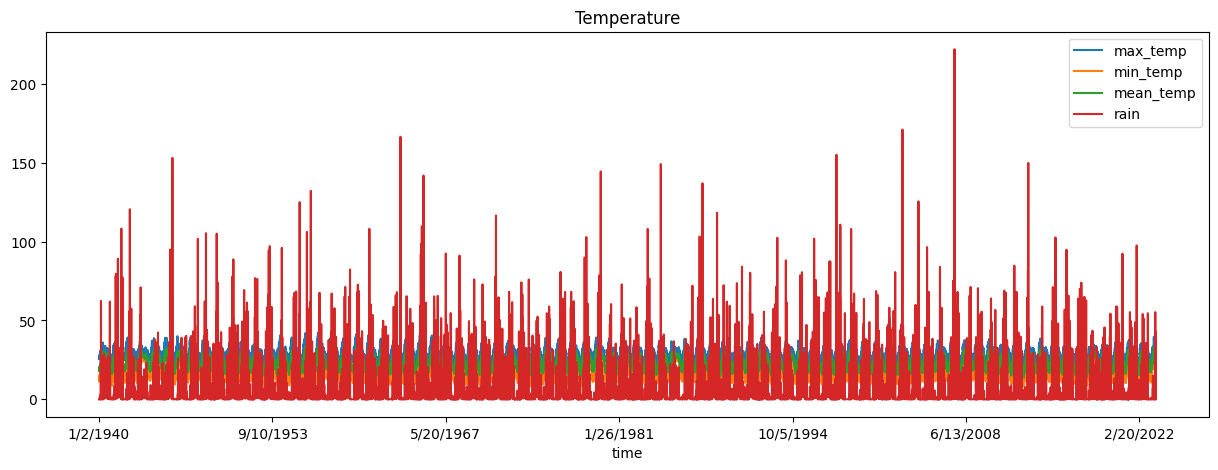

In [17]:
df.plot(x='time', y=['max_temp', 'min_temp', 'mean_temp', 'rain'], figsize=(15,5), title='Temperature')

<ipython-input-18-84a928a2257d>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4, i + 1)
<ipython-input-18-84a928a2257d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[col])
<ipython-input-18-84a928a2257d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the 

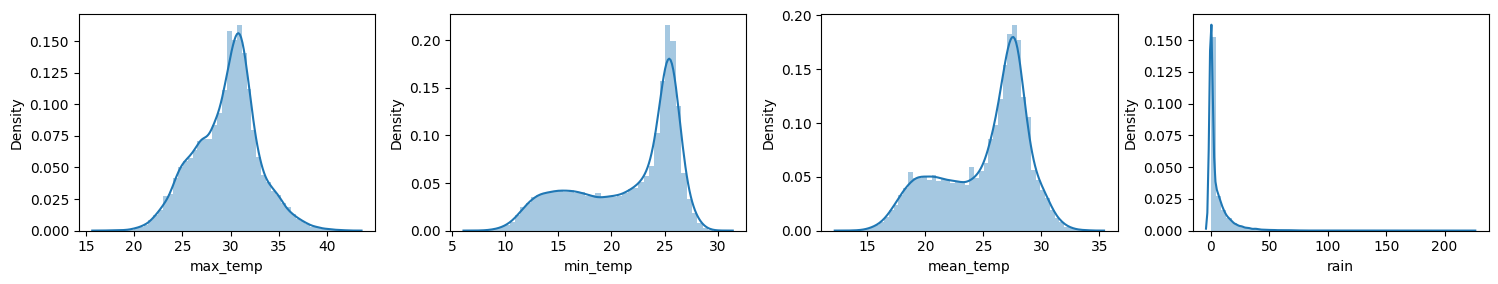

In [18]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
  plt.subplot(3,4, i + 1)
  sb.distplot(df[col])
plt.tight_layout()
plt.show()

<ipython-input-19-70eb1f148cea>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4, i + 1)


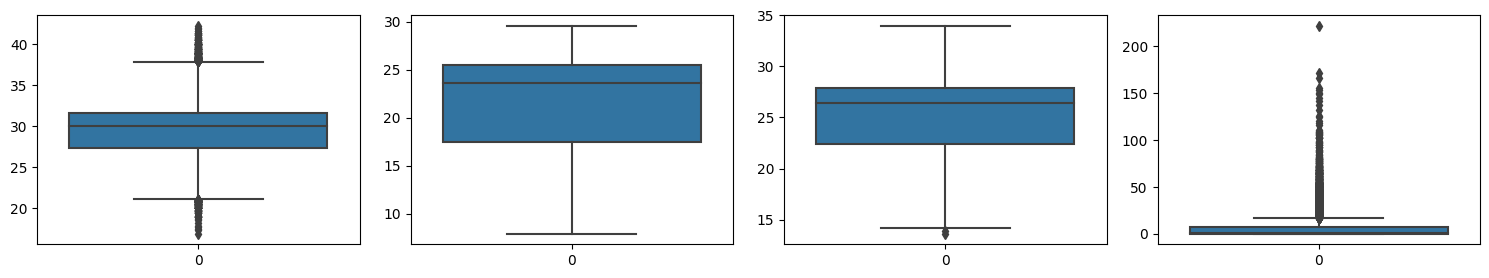

In [19]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
  plt.subplot(3,4, i + 1)
  sb.boxplot(df[col])
plt.tight_layout()
plt.show()

In [20]:
df_temp = df[['mean_temp']]
df_temp.index = pd.to_datetime(df[['time']].stack(), format='%m%d%y', errors='ignore')

df_temp.head()

,mean_temp
1/2/1940,18.2
1/3/1940,18.2
1/4/1940,18.0
1/5/1940,18.3
1/6/1940,18.1


In [25]:
train_size = int(len(df_temp) * 0.8)
test_size = len(df_temp) - train_size
train, test = df_temp.iloc[0:train_size], df_temp.iloc[train_size:len(df_temp)]
print(len(train), len(test))

24380 6095


In [24]:
scaler = MinMaxScaler()
scaler = scaler.fit(train[['mean_temp']])

train['mean_temp'] = scaler.transform(train[['mean_temp']])
test['mean_temp'] = scaler.transform(test[['mean_temp']])

<ipython-input-24-25ae14dcfe10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mean_temp'] = scaler.transform(train[['mean_temp']])
<ipython-input-24-25ae14dcfe10>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mean_temp'] = scaler.transform(test[['mean_temp']])


In [27]:
def create_sequences(train, mean_temp, time_steps=1):
    x_train = []
    y_train = []
    for value in range(len(train) - time_steps):
        temps = train.iloc[value:(value + time_steps)].values
        x_train.append(temps)
        y_train.append(mean_temp.iloc[value + time_steps])
    return np.array(x_train), np.array(y_train)

time_steps = 5

x_train, y_train = create_sequences(train, train.mean_temp, time_steps)
x_test, y_test = create_sequences(test, test.mean_temp, time_steps)

print(x_train.shape, y_train.shape)

(24375, 5, 1) (24375,)
